In [271]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm


In [272]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
import RS_train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}

In [274]:
dataset = RS_dataset.Seg_RS_dataset_edge_v2(img_dir=selected_paths_img, mask_dir=selected_paths_mask, 
                                                  image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP,
                                                  gaussian=False,
                                                  mask_onehot=True, 
                                                  softmax=True)

In [275]:
rad_int = np.random.randint(0,400)
#rad_int = 11
print(rad_int)
img, mask,_ = dataset.__getitem__(rad_int)

152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


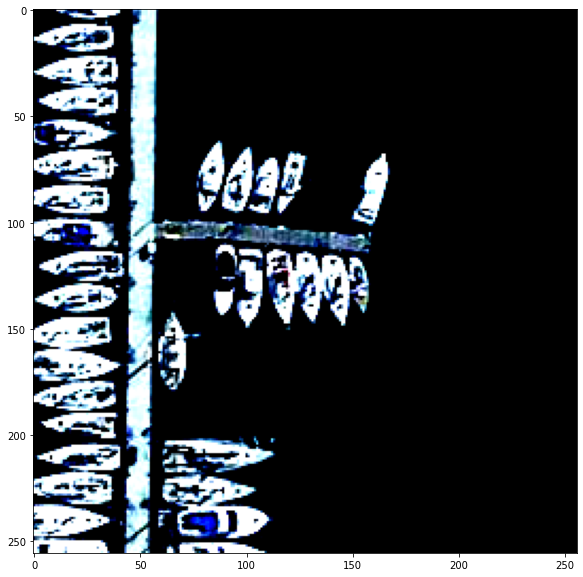

In [276]:
RS_utils.torch_display(img)

In [277]:
mask.shape

torch.Size([256, 256])

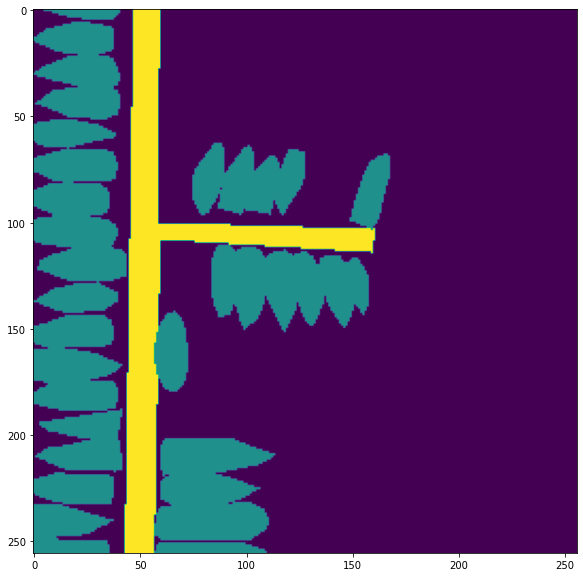

In [278]:
RS_utils.torch_display_mask(mask)

In [279]:
model_1 = smp.UnetPlusPlus(encoder_name="resnet152",classes=3)
model_2 = RS_models.Edge_Net(input_channel=3)
model = RS_models.CombinedModel(model_1, model_2)

In [280]:
aa = "./02.ckpts"
w_path = sorted(glob(os.path.join(aa, "*.pt")))[-1]
w_path = "./02.ckpts/ver_73_SHIP_UNET_with_EDGE_v_ddp_epoch_141_iteration_656496.pt"
print(w_path)

./02.ckpts/ver_73_SHIP_UNET_with_EDGE_v_ddp_epoch_141_iteration_656496.pt


In [281]:
weights_ = torch.load(w_path, map_location=torch.device('cpu'))
model.load_state_dict(weights_)
model = model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


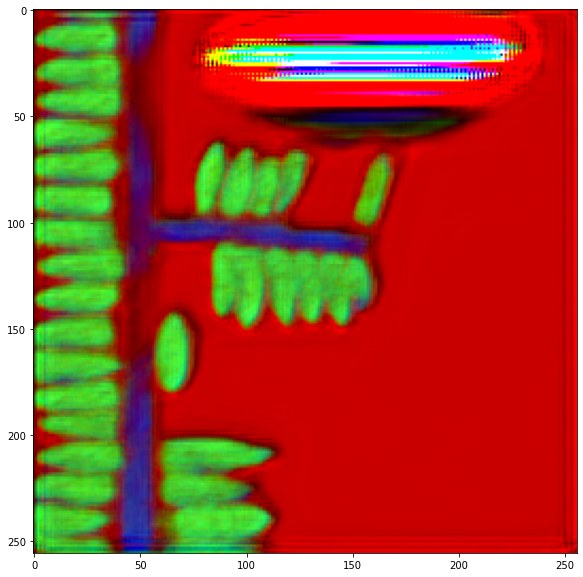

In [282]:
img_ = img.unsqueeze(0)
pred = model.forward_eval(img_)
pred_ = pred.squeeze(0)
pred_ = pred_.detach().cpu()

print(pred_.shape)
RS_utils.torch_display(pred_)

In [283]:
torch.mean(pred)

tensor(0.2728, grad_fn=<MeanBackward0>)

In [284]:
# vanilla unet model 

vanilla_model = smp.UnetPlusPlus(encoder_name="resnet152",classes=3)
p_path ="/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/07.Unet_PlusPlus_EdgeNet/02.ckpts/ver_35_unet_epoch_101_iteration_470256.pt"
weights_ = torch.load(p_path, map_location=torch.device('cpu'))
vanilla_model.load_state_dict(weights_)
vanilla_model = vanilla_model.eval()

#--
img_ = img.unsqueeze(0)
pred_v = vanilla_model(img_)
pred_vs = pred_v.squeeze(0)
pred_vs = pred_vs.detach().cpu()
# pred_v = torch.argmax(pred_v, dim=1)

In [285]:
pred_v.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


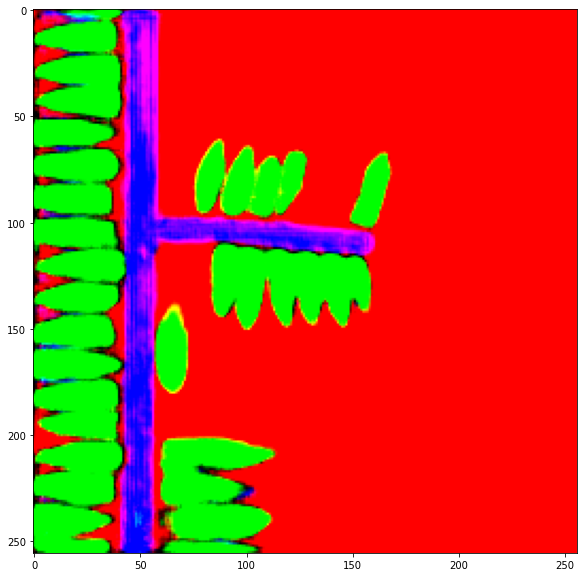

In [286]:
RS_utils.torch_display(pred_vs)

In [301]:
pred.shape

torch.Size([1, 3, 256, 256])

In [305]:
pred.shape

torch.Size([1, 3, 256, 256])

In [312]:
check = torch.where(pred > 0.5, True, False) 
check = check.squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


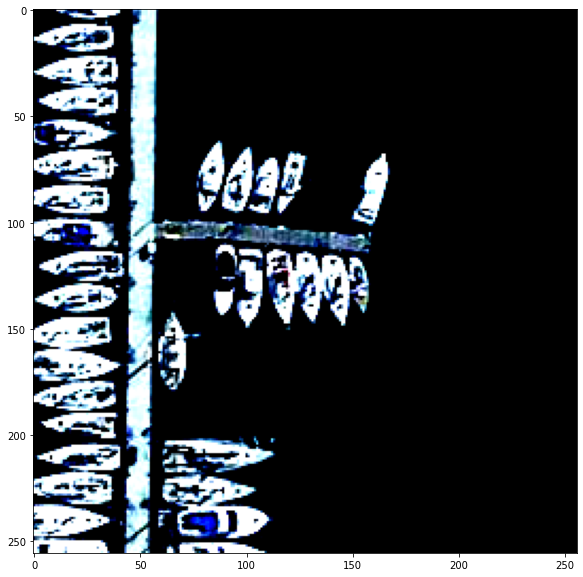

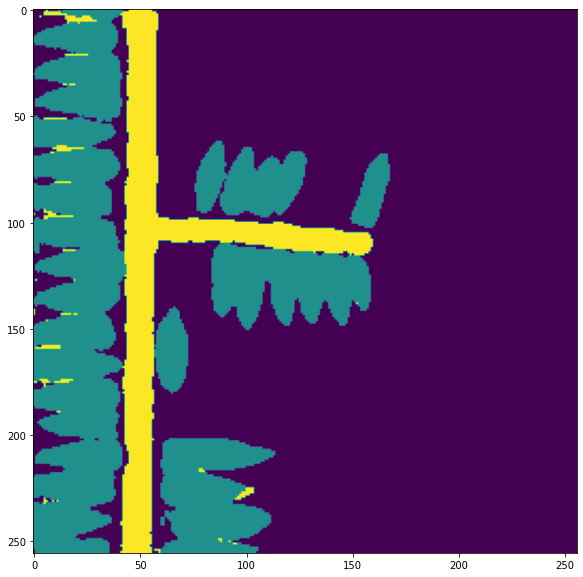

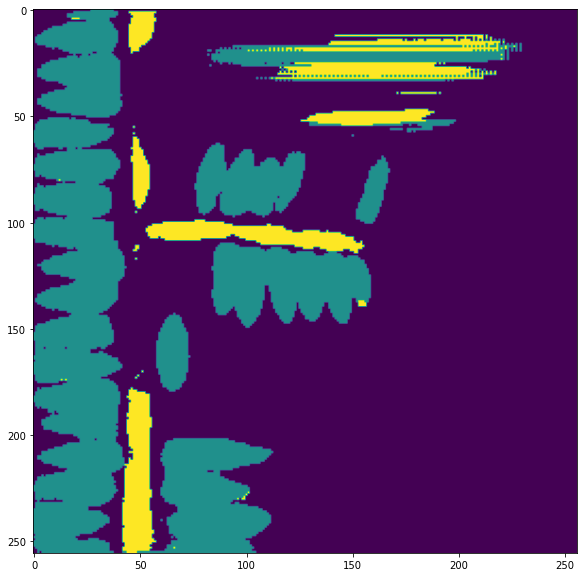

In [287]:
RS_utils.torch_display(img)


pred_v_mask = torch.argmax(pred_v, dim=1)
RS_utils.torch_display(pred_v_mask)

#pred_mask = torch.argmax(pred, dim=1)

RS_utils.torch_display(pred_mask)


In [288]:
RS_utils.torch_display(pred)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3